In [1]:
import json
import numpy as np
import glob
import matplotlib.pyplot as plt
from common.trajectory_analysis import Trajectory
from common.util import DelayLine
from scipy import signal


In [18]:
b = -1/3
varc = 10
varv = 0.1

print(  (1+b)**2 * varc / (varc + varv))

0.44004400440044017


In [2]:
files = glob.glob("..//data1//*.txt")

lowpass_cutoff = 10 # Hz
dt = 0.005
A = np.array
pxtomm = 1/10.8

data = []
for f in files:
    d = json.load(open(f))
    d["filename"] = f
    ts = [d["ts"][i] - d["ts"][0] for i in range(len(d["ts"]))]
    tx = A(d["tx"]) * pxtomm
    ty = A(d["ty"]) * pxtomm
    cx = A(d["cx"]) * pxtomm
    cy = A(d["cy"]) * pxtomm
    
    d["target"] = Trajectory(tx, ty, ts, dt=dt, cut = [0, 0]).calc_betas()
    d["cursor"] = Trajectory(cx, cy, ts, dt=dt, cut = [0, 0], smooth = lowpass_cutoff).calc_betas()
    data.append(d)


In [3]:
class Oscillator:
    def __init__(s, dt, A=1, B=1, cx=0, cy=0, init_phase=0):
        s.x = np.cos(init_phase)
        s.y = np.sin(init_phase)
        s.dt = dt
        s.cx = cx
        s.cy = cy
        s.out = np.array([s.cx + A * s.x, s.cy + B * s.y])
            
    def step(s, f, A=1, B=1):
        s.y +=  -s.x *  f * s.dt * 2 * np.pi
        s.x +=   s.y *  f * s.dt * 2 * np.pi
        s.out = np.array([s.cx + A * s.x, s.cy + B * s.y])


In [4]:
class FirstOrderModel:
    def __init__(self, K, B, tau, dt, init_err=0, init_out=0):
        self.K = K
        self.B = B
        self.tauN = int(tau / dt)
        self.delayed_err = DelayLine(self.tauN, init_err)
        self.dt = dt
        self.out = init_out

    def step(self, new_p, new_r):
        new_err = new_r - new_p
        e = self.delayed_err(new_err)
        self.out = self.out + (self.K * e - self.B*self.out) * dt      
        

In [5]:
class Store:
    "helper class for storing simulation results"
    def __init__(self, *names):
        self.names = names
        for n in names: setattr(self, n, [])
            
    def step(self, *d):
        for i in range(len(d)):
            n = self.names[i]
            var = getattr(self, n) 
            var.append(d[i])

def butterworth(x, cutoff, samples_per_s=200, filter_order=2):
    B, A = signal.butter(filter_order, cutoff / (samples_per_s / 2), 'low')
    return signal.filtfilt(B, A, x, method="gust")

def rmse(a, b):
    ds = (a - b)**2
    return np.sqrt(np.mean(ds))

def distance(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5            

In [6]:
dt = 1./200.

centerx, centery = center = 87.99, 51.66 ## mm
radiusx, radiusy = radius = 34.0, 19.3   ## mm
radius_ratio = radiusx / radiusy


freqs = [0.27, 0.40, 0.54, 0.67, 0.81, 0.94, 1.07, 1.21, 1.34]

targets = []

for idx in range(len(data)):
    fn = data[idx]["filename"]
    if "am2" in fn:        
        t = data[idx]["target"]
        t.filename = fn
        fn_speed = int(fn.split()[6])
        t.freq = freqs[int((fn_speed - 3) /2)]
        t.betaCV = float(fn.split()[4][4:]) - 1
        t.phase = np.unwrap(np.arctan2(t.y-centery, t.x-centerx))
        
        t.human = data[idx]["cursor"]
        t.human.cph = np.unwrap(np.arctan2(t.human.y - centery, t.human.x - centerx))
        t.human.dph = t.human.cph - t.phase    
        t.human.r =  np.array([distance((t.human.x[i], t.human.y[i]), center) for i in range(len(t.human.t))])    
        t.human.rc = t.human.r *  np.sqrt(np.cos(t.human.cph)**2 + (radius_ratio*np.sin(t.human.cph))**2)
        t.human.ds = radiusx - t.human.rc
                
        targets.append(t)
        

targets.sort(key = lambda x: int(x.filename.split()[6])) # sort by frequency

In [7]:
colors = {
    "target": "#882255",
    "cursor": "#44AA99",
    "virtual":"#547dde",
    "model" : "#f6914b"
}


In [8]:
radius_ratio

1.761658031088083

..//data1\tracking am2 v2 e0.9 beta0.333333  speed 3 2017-02-04 15-53-59.txt


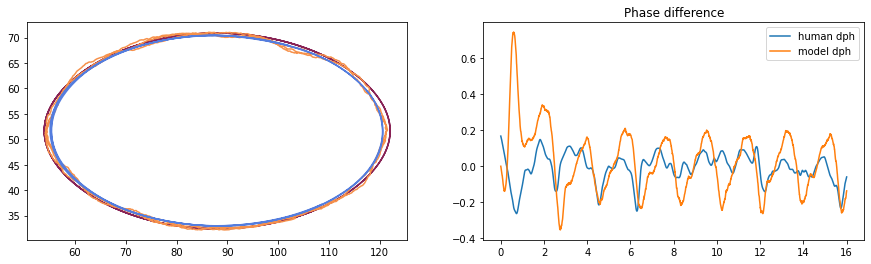

..//data1\tracking am2 v2 e0.9 beta0.666666  speed 3 2017-02-04 15-51-13.txt


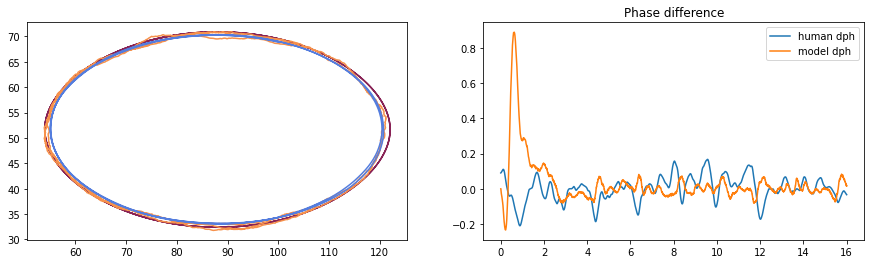

..//data1\tracking am2 v2 e0.9 beta1.0  speed 3 2017-02-04 15-54-19.txt


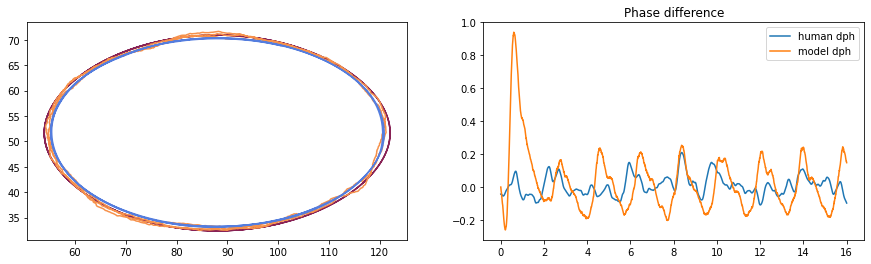

..//data1\tracking am2 v2 e0.9 beta0.333333  speed 5 2017-02-04 15-50-53.txt


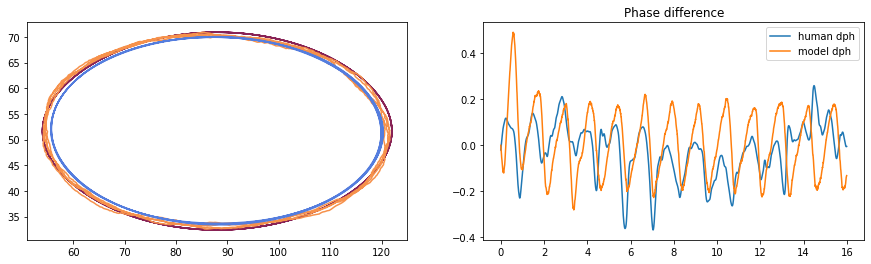

..//data1\tracking am2 v2 e0.9 beta0.666666  speed 5 2017-02-04 15-47-38.txt


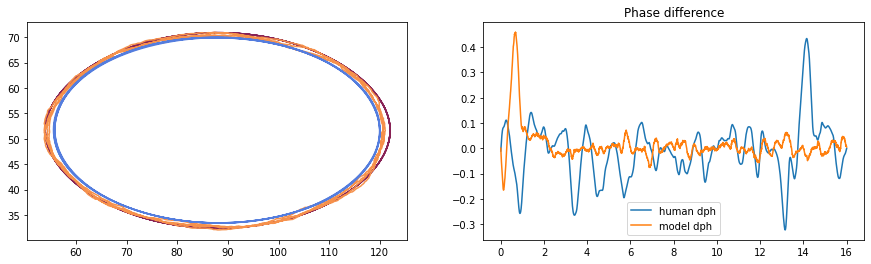

..//data1\tracking am2 v2 e0.9 beta1.0  speed 5 2017-02-04 15-52-55.txt


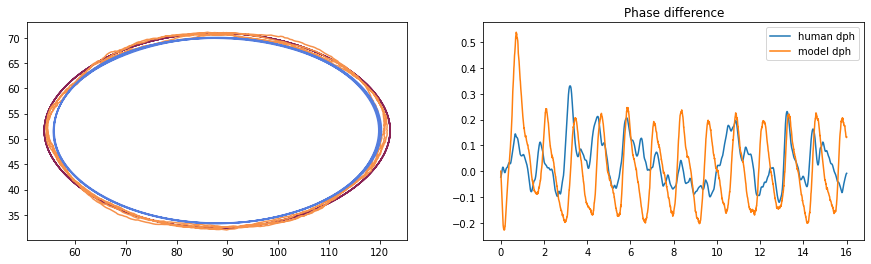

..//data1\tracking am2 v2 e0.9 beta0.333333  speed 7 2017-02-04 15-55-18.txt


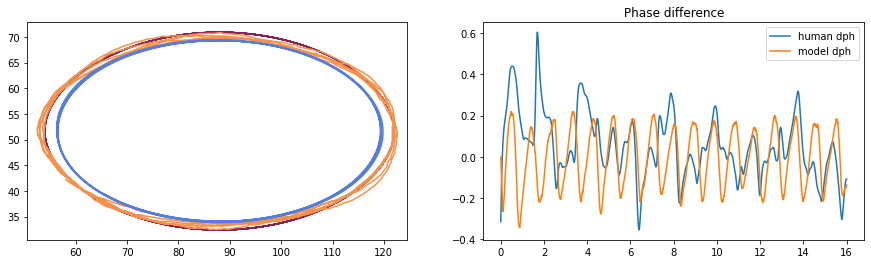

..//data1\tracking am2 v2 e0.9 beta0.666666  speed 7 2017-02-04 15-46-58.txt


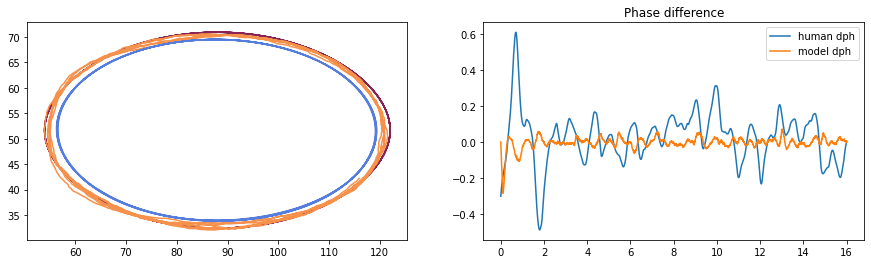

..//data1\tracking am2 v2 e0.9 beta1.0  speed 7 2017-02-04 15-49-47.txt


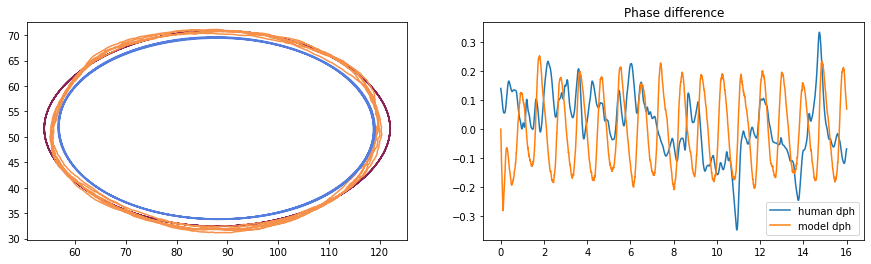

..//data1\tracking am2 v2 e0.9 beta0.333333  speed 9 2017-02-04 15-53-15.txt


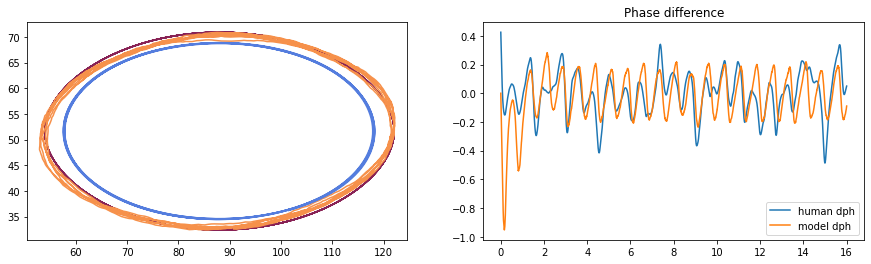

..//data1\tracking am2 v2 e0.9 beta0.666666  speed 9 2017-02-04 15-54-39.txt


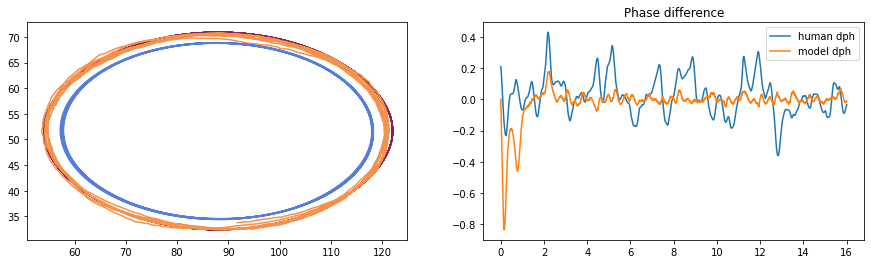

..//data1\tracking am2 v2 e0.9 beta1.0  speed 9 2017-02-04 15-48-00.txt


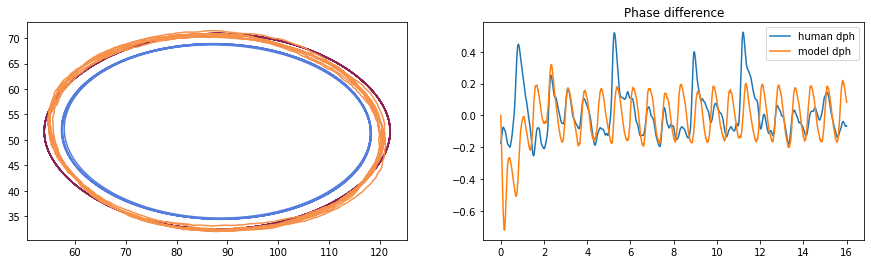

..//data1\tracking am2 v2 e0.9 beta0.333333  speed 11 2017-02-04 15-52-34.txt


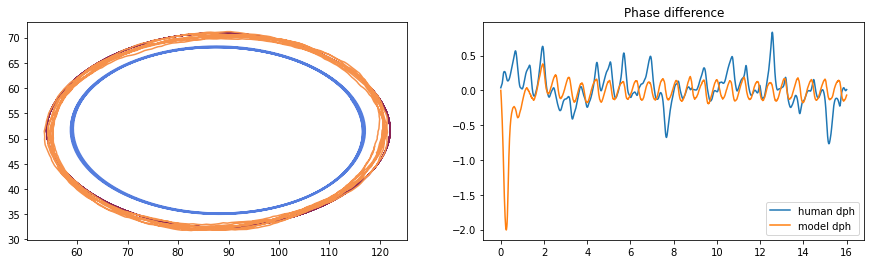

..//data1\tracking am2 v2 e0.9 beta0.666666  speed 11 2017-02-04 15-46-17.txt


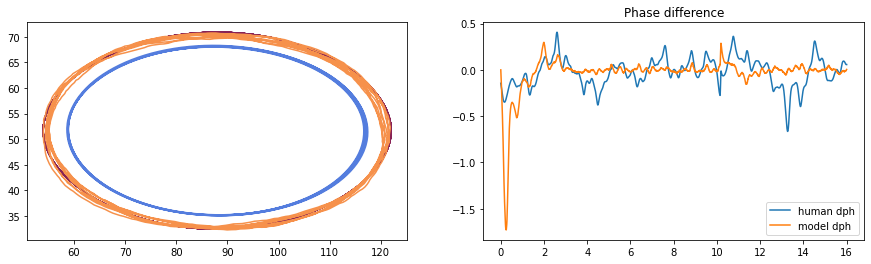

..//data1\tracking am2 v2 e0.9 beta1.0  speed 11 2017-02-04 15-53-35.txt


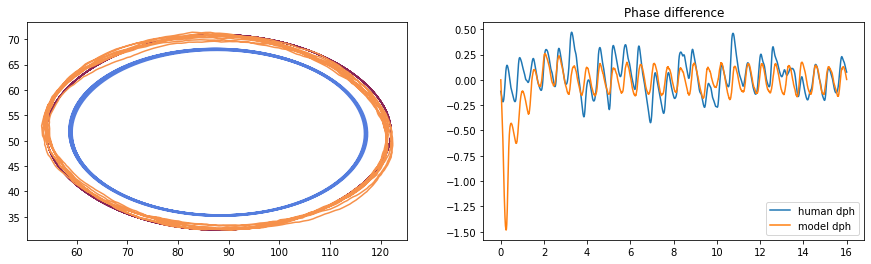

..//data1\tracking am2 v2 e0.9 beta0.333333  speed 13 2017-02-04 15-50-32.txt


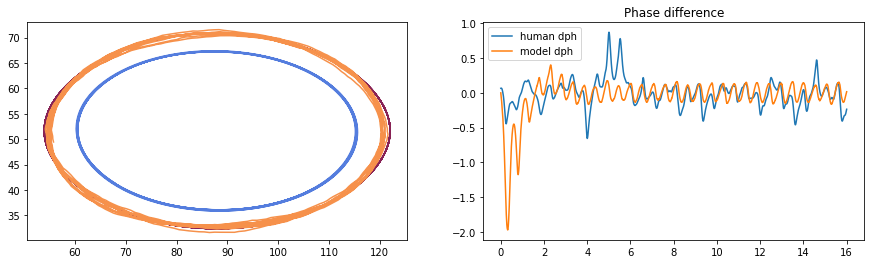

..//data1\tracking am2 v2 e0.9 beta0.666666  speed 13 2017-02-04 15-52-13.txt


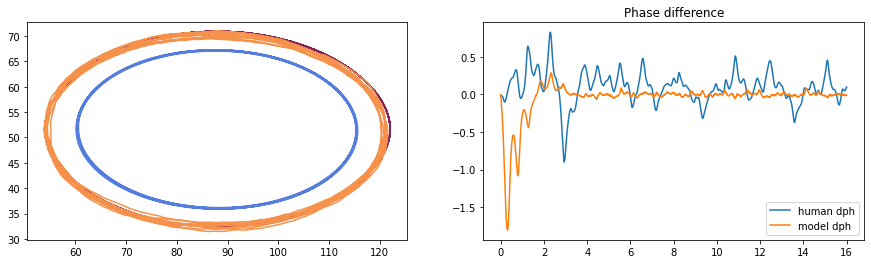

..//data1\tracking am2 v2 e0.9 beta1.0  speed 13 2017-02-04 15-46-38.txt


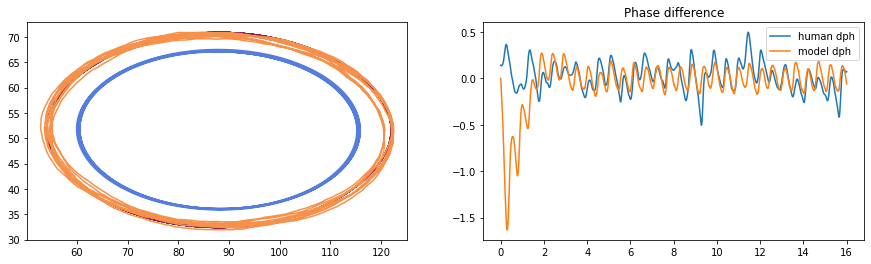

..//data1\tracking am2 v2 e0.9 beta0.333333  speed 15 2017-02-04 15-47-18.txt


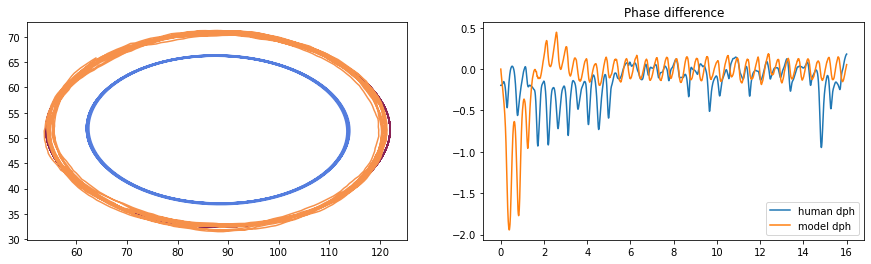

..//data1\tracking am2 v2 e0.9 beta0.666666  speed 15 2017-02-04 15-48-21.txt


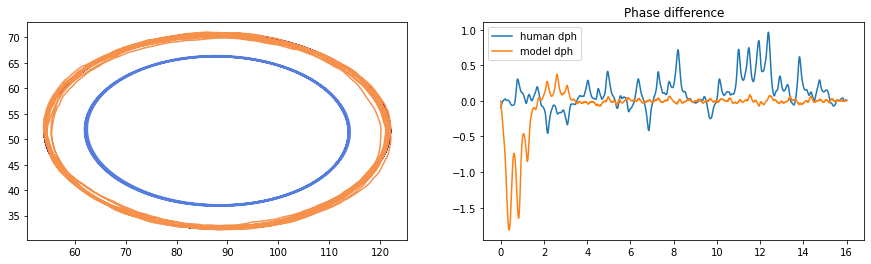

..//data1\tracking am2 v2 e0.9 beta1.0  speed 15 2017-02-04 15-51-33.txt


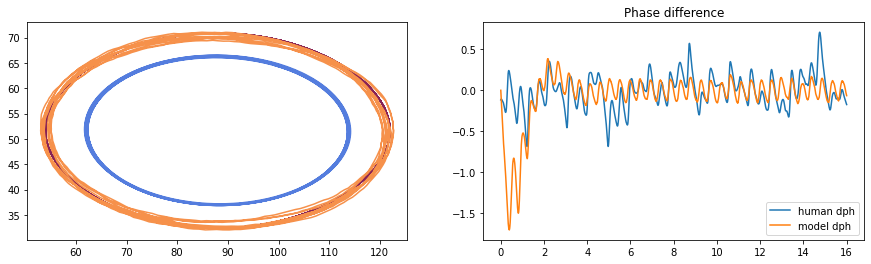

..//data1\tracking am2 v2 e0.9 beta0.333333  speed 17 2017-02-04 15-54-59.txt


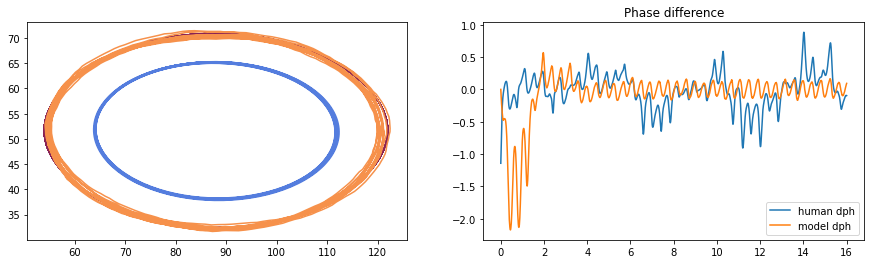

..//data1\tracking am2 v2 e0.9 beta0.666666  speed 17 2017-02-04 15-48-41.txt


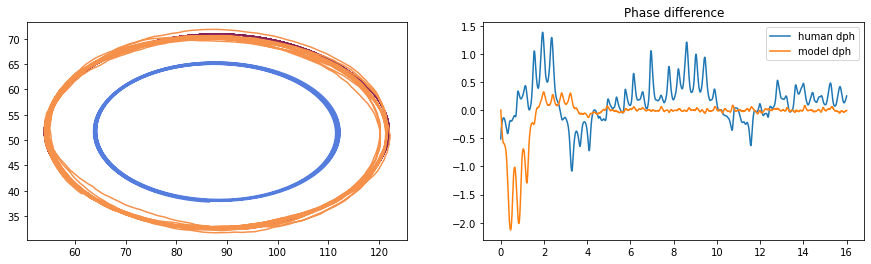

..//data1\tracking am2 v2 e0.9 beta1.0  speed 17 2017-02-04 15-51-53.txt


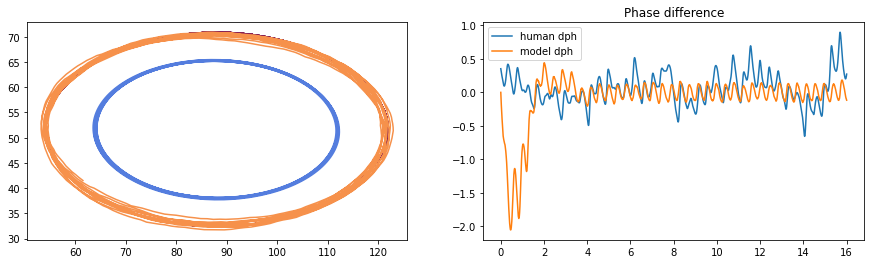

..//data1\tracking am2 v2 e0.9 beta0.333333  speed 19 2017-02-04 15-50-08.txt


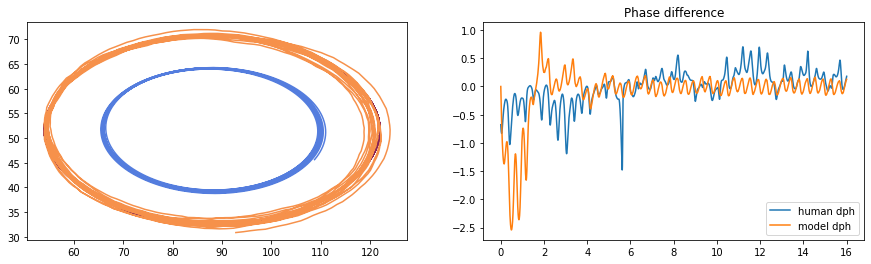

..//data1\tracking am2 v2 e0.9 beta0.666666  speed 19 2017-02-04 15-49-26.txt


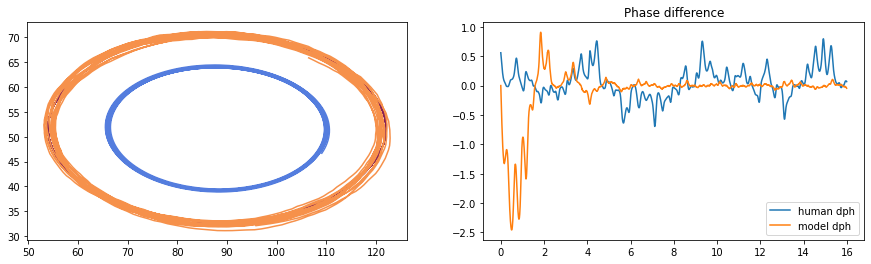

..//data1\tracking am2 v2 e0.9 beta1.0  speed 19 2017-02-04 15-49-03.txt


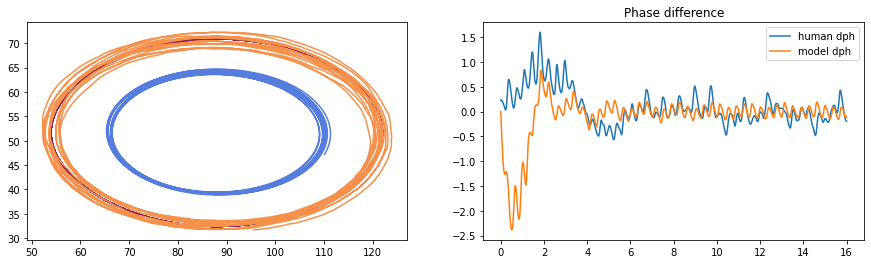

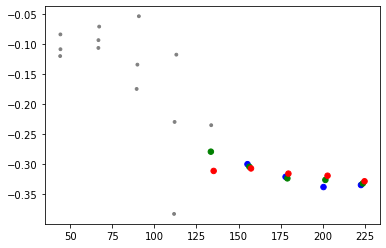

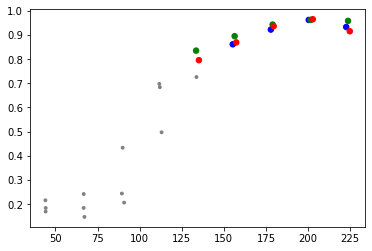

In [9]:

for t in targets:
    print(t.filename)
    target0 = np.array([t.x[0], t.y[0]])
    osc = Oscillator(dt, radiusx, radiusy, centerx, centery, t.phase[0])
    
    m = FirstOrderModel(10, 0.018, 0.100, dt, init_out=target0, init_err=np.array([0, 0]))
    
    cph = np.arctan2(m.out[1] - centery, m.out[0] - centerx); 
    prev_cph = cph
    
    rx, ry = radiusx, radiusy
    
    last_dph = cph  - t.phase[0]
    last_rdif = 0
    f = -0.5
    
    prev_size_err = 0

    delayed_phase     = DelayLine(int(0.00 / dt), 0)
    delayed_size_err  = DelayLine(int(0.150 / dt), 0)
    
    s = Store("mx", "my", "ox", "oy", "tph", "cph", "dph", "vdph", "f", "size_err", "rc", "size_ref")

    for i in range(len(t.t)):
        tph = t.phase[i]
        cph0 = np.arctan2(m.out[1] - centery, m.out[0] - centerx)
        cph  = np.unwrap([prev_cph, cph0])[1]; prev_cph = cph

        dph = delayed_phase(cph - tph)            
        vdph = (dph - last_dph) / dt
        last_dph = dph
        f = f + (0.5*dph + 0.3*vdph ) * dt 

        # get the size error and calculate rx and ry            
        r = distance(m.out, center) 
        rc = r *  np.sqrt(np.cos(cph)**2 + (radius_ratio*np.sin(cph))**2)
        size_ref = radiusx
        size_err = delayed_size_err(size_ref - rc)

        sv = (size_err - prev_size_err)/dt
        prev_size_err = size_err            
        
        rx = rx + (1.33 * size_err - 0.016 * sv - rx*0.033) * dt
        ry = rx / radius_ratio

        osc.step(f, rx, ry)
        m.step(m.out, osc.out)            
        
        noise = np.random.normal(size=m.out.size, loc=0, scale=0.06)            
        m.out += noise

        # store variables
        s.step(*m.out, *osc.out, tph, cph, dph, vdph, f, size_err, rc, size_ref)

    
    time = np.arange(len(s.mx)) * dt
    t.mV = ((np.gradient(s.mx)/dt)**2 + (np.gradient(s.my)/dt)**2)**0.5
    
    # cut start and smooth to calc betas 
    t.model = Trajectory(s.mx, s.my, time, dt=dt, cut=[5,1], smooth=10)
    t.model.calc_betas(orthogonal=True)
    
    # no cut, smoothed
    t.m2 = Trajectory(s.mx, s.my, time, dt=dt, smooth=10)  
    
    # raw
    t.data = s
    
    
    plt.figure(figsize=[15,4])
    plt.subplot(121)
    cut = int(6.0/dt)
    plt.plot(t.x[cut:], t.y[cut:], label="target", color=colors["target"])
    plt.plot(s.mx[cut:], s.my[cut:], label="model", color=colors["model"])
    plt.plot(s.ox[cut:], s.oy[cut:], label="ref oscillator", color=colors["virtual"])
    plt.axis("equal")
    plt.subplot(122)
    plt.title("Phase difference")
        
    plt.plot(time, t.human.dph, label="human dph")
    plt.plot(time, s.dph, label="model dph")
    
    plt.legend()
    plt.show()
    
    
speeds     = [np.mean(t.model.V) for t in targets]
betas      = [t.model.betaCV for t in targets ]
r2s        = [t.model.r2CV for t in targets]
targ_betas = [round(t.betaCV/(-1/3)) for t in targets]
clrs       = ["gray" if r2s[i] < 0.75 else ["red", "green", "blue"][targ_betas[i]] for i in range(len(targ_betas))]
sizes      = [ 30 if r2 > 0.75 else 8 for r2 in r2s]   

plt.scatter(speeds, betas, c=clrs, s = sizes)
plt.show()

plt.scatter(speeds, r2s, c=clrs, s=sizes)
plt.show()

In [10]:
slows = [t for t in targets if "speed 3" in t.filename]
slows.sort(key = lambda x: x.betaCV, reverse=True)

fasts = [t for t in targets if "speed 19" in t.filename]
fasts.sort(key = lambda x: x.betaCV, reverse=True)


In [11]:
import matplotlib
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 16}
matplotlib.rc('font', **font)



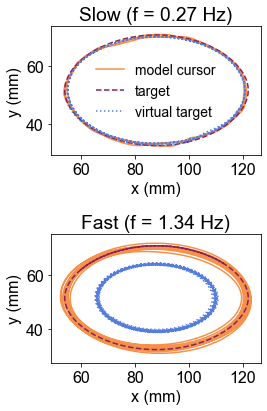

In [23]:

t = slows[0]
c = t.m2


fig, axs = plt.subplots(2,1, figsize=(4, 6))
ax = axs[0]
ax.set_title("Slow (f = 0.27 Hz)")

cut = int(5/dt)
ax.plot(c.x[cut:], c.y[cut:], color=colors["model"], label="model cursor")
take = np.arange(int(1/dt), int(4.75/dt))
ax.plot(t.x[take], t.y[take], '--', color=colors["target"], label="target")
ax.plot(t.data.ox, t.data.oy, ":", color=colors["virtual"], label="virtual target")
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(frameon=False, prop={'size':14})

ax = axs[1]
ax.set_title("Fast (f = 1.34 Hz)")

t = fasts[0]
c = t.m2
cut = int(5/dt)

ax.plot(c.x[cut:], c.y[cut:], color=colors["model"], label="model cursor")
take = np.arange(int(1/dt), int(2/dt))
ax.plot(t.x[take], t.y[take], '--', color=colors["target"], label="target")
ax.plot(t.data.ox[cut:], t.data.oy[cut:], ":", color=colors["virtual"], label="virtual target")
ax.axis("equal")
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")

axs[0].set_xlim(axs[1].get_xlim())
axs[0].set_ylim(axs[1].get_ylim())


plt.tight_layout()
plt.savefig("../figures/Figure5 positions.eps", format="eps", bbox_inches = "tight")
plt.show()


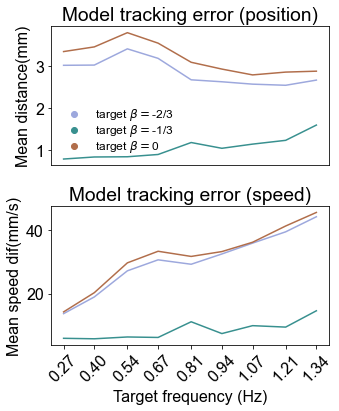

In [25]:
def rmse(a, b): return (((a - b)**2).mean())**0.5

m00 =  [t for t in targets if round(t.betaCV/(-1/3)) == 0 ]
m033 = [t for t in targets if round(t.betaCV/(-1/3)) == 1 ]
m066 = [t for t in targets if round(t.betaCV/(-1/3)) == 2 ]

beta_colors = ["#9da8dd", "#38908f", "#b16e4B"]


fig1, [ax1, ax2] = plt.subplots(2,1,figsize=(5,6))


cut = 6
ax1.set_title("Model tracking error (position)")
for clr, ms in enumerate([m00, m033, m066]):
    fits = []
    for t in ms:
        tcd = [ (t.x[i] - t.m2.x[i])**2 +(t.y[i] - t.m2.y[i])**2 for i in range(int(cut/dt), len(t.m2.t))]
        mean_dist = np.mean(np.sqrt(tcd))
        fits.append(mean_dist)
    freqs_i = [t.freq for t in ms]
    color  = beta_colors[clr]
    ax1.plot(freqs_i, fits, '-', color=color)
    
    
ax2.set_title("Model tracking error (speed)")
for clr, ms in enumerate([m00, m033, m066]):
    freqs_i = [t.freq for t in ms]
    fits   = [rmse(t.V[int(cut/dt):], t.m2.V[int(cut/dt):]) for t in ms]
    color  = beta_colors[clr]
    ax2.plot(freqs_i, fits, '-', color=color)


for i in range(3):
    ax1.scatter([],[], color=beta_colors[i], label=fr"target $\beta=${['-2/3', '-1/3', '0'][i]}")
    
ax1.legend(prop={'size':12},labelspacing=0.0, frameon=False, loc="lower left")
ax1.set_ylabel("Mean distance(mm)")
ax2.set_ylabel("Mean speed dif(mm/s)")
ax1.set_xticks([])

ax2.set_xticks(freqs)
ax2.tick_params(axis='x', labelrotation = 45)
ax2.set_xlabel("Target frequency (Hz)")

plt.tight_layout()
plt.savefig("..//figures//Figure 5 tracking error.eps", format="eps", bbox_inches = "tight")
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


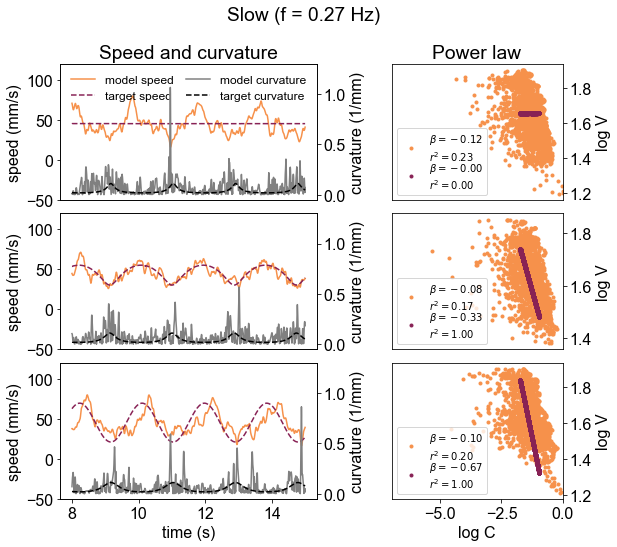

In [27]:


fig, axs = plt.subplots(3,2, figsize=(9, 8), gridspec_kw={'width_ratios': [1.5, 1]})

for i in [0,2,1]:
    c = slows[i].model
    t = Trajectory(slows[i].x, slows[i].y, slows[i].t, dt=dt, smooth=None, cut = [5,1]).calc_betas()
    
    
    ax0 = axs[i, 0]
    ax1 = ax0.twinx()
    
    take = np.arange(int(3/dt), int(10/dt))
    ax0.plot(c.t[take], c.V[take], color=colors["model"], label="model speed")
    ax0.plot(t.t[take], t.V[take], '--', color=colors["target"], label="target speed")
    ax0.set_ylabel("speed (mm/s)")
    ax1.plot(c.t[take], c.C[take], label="model curvature", color="gray")
    ax1.plot(t.t[take], t.C[take], "--", label="target curvature", color="black")
    
    ax1.set_ylabel("curvature (1/mm)")
    
    if i == 2: 
        ax0.set_xlabel("time (s)")
    else:
        ax0.set_xticks([])
    
    ax0.set_ylim(-50, 120)
    ax1.set_ylim(-0.05, 1.3)
    if i==0: 
        ax0.set_title("Speed and curvature")    
        ax0.legend(loc ="upper left", frameon=False,prop={'size':12})
        ax1.legend(loc ="upper right", frameon=False,prop={'size':12})
    
        
    ax = axs[i, 1]
    if i==0: ax.set_title("Power law")    
    ax.plot(c.logC, c.logV, '.', color=colors["model"], label=fr"$\beta = {c.betaCV:.2f}$""\n"  fr"$r^2 = {c.r2CV:.2f}$" )
    #x12 = np.array([np.min(c.logC), np.max(c.logC)])
    #y12 = c.betaCV * x12 + c.offsetCV 
    #ax.plot(x12, y12, '-', color="black", label=r"$\beta$={:.3f}".format(c.betaCV))
    
    ax.plot(t.logC, t.logV, '.', color=colors["target"], label=fr"$\beta = {t.betaCV:.2f}$" "\n"fr"$r^2 = {t.r2CV:.2f}$" )
    
    if i==2: 
        ax.set_xlabel("log C")
    else:
        ax.set_xticks([])
    ax.set_xlim(-7,0)
    ax.set_ylabel("log V")
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.legend(loc="lower left", prop={'size':10}, labelspacing=-0.2)
    
    
plt.suptitle("Slow (f = 0.27 Hz)")   
plt.subplots_adjust(wspace=0.35, hspace=0.1)

plt.savefig("..//figures//Figure 5 model human slow.eps", format="eps", bbox_inches = "tight")
plt.show()

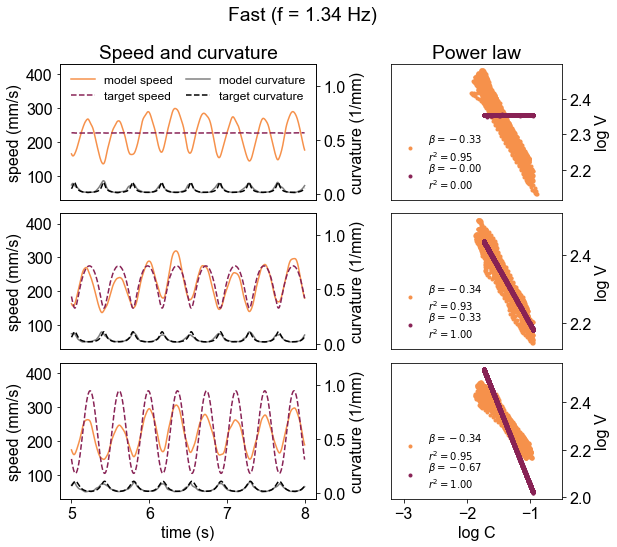

In [28]:


fig, axs = plt.subplots(3,2, figsize=(9, 8), gridspec_kw={'width_ratios': [1.5, 1]})

for i in range(3):
    c = fasts[i].model
    t = Trajectory(fasts[i].x, fasts[i].y, fasts[i].t, dt=dt, cut=[5,1]).calc_betas()
    
    ax0 = axs[i, 0]
    ax1 = ax0.twinx()
    
    take = np.arange(int(0/dt), int(3/dt))
    ax0.plot(c.t[take], c.V[take], color=colors["model"], label="model speed")
    ax0.plot(t.t[take], t.V[take], '--', color=colors["target"], label="target speed")
    ax0.set_ylabel("speed (mm/s)")
    ax1.plot(c.t[take], c.C[take], label="model curvature", color="gray")
    ax1.plot(t.t[take], t.C[take], "--", label="target curvature", color="black")
    
    ax1.set_ylabel("curvature (1/mm)")
    
    if i == 2: 
        ax0.set_xlabel("time (s)")
    else:
        ax0.set_xticks([])
    
    ax0.set_ylim(30, 430)
    ax1.set_ylim(-0.05, 1.2)
    if i==0: 
        ax0.set_title("Speed and curvature")    
        ax0.legend(loc ="upper left", frameon=False,prop={'size':12})
        ax1.legend(loc ="upper right", frameon=False,prop={'size':12})
    
        
    ax = axs[i, 1]
    if i==0: ax.set_title("Power law")    
    ax.plot(c.logC, c.logV, '.', color=colors["model"], label=fr"$\beta = {c.betaCV:.2f}$""\n"  fr"$r^2 = {c.r2CV:.2f}$" )

    ax.plot(t.logC, t.logV, '.', color=colors["target"], label=fr"$\beta = {t.betaCV:.2f}$" "\n"fr"$r^2 = {t.r2CV:.2f}$" )
    
    if i==2: 
        ax.set_xlabel("log C")
    else:
        ax.set_xticks([])
    ax.set_xlim(-3.2,-0.5)
    ax.set_ylabel("log V")
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.legend(loc="lower left", prop={'size':10}, labelspacing=-0.2, frameon=False)
    
    
plt.suptitle("Fast (f = 1.34 Hz)")    
plt.subplots_adjust(wspace=0.35, hspace=0.1)

plt.savefig("..//figures//Figure 5 model human Fast.eps", format="eps", bbox_inches = "tight")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


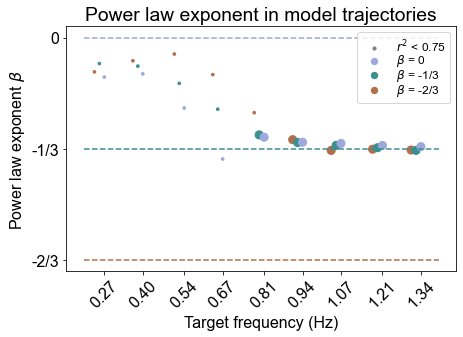

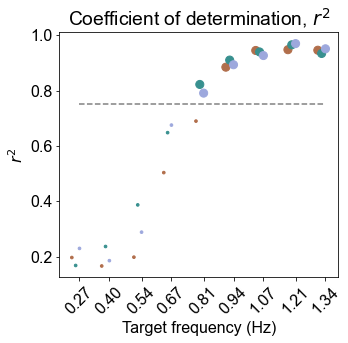

In [29]:
data = targets

freqs_t  = [d.freq+ d.betaCV * 0.05 for d in data]


beta_colors = ["#9da8dd", "#38908f", "#b16e4B"]

betas  = [d.model.betaCV for d in data]
r2s    = [d.model.r2CV   for d in data]
tb     = [0 if "beta1.0" in d.filename else 1 if "beta0.6" in d.filename else 2 for d in data]

clrs     = [beta_colors[tb[i]] for i in range(len(r2s))]
sizes    = [65 if r2 >= 0.75 else 7 for r2 in r2s]

plt.figure(figsize=(7, 4.5))

plt.plot([0.2, 1.4], [0, 0], "--", color=beta_colors[0])
plt.plot([0.2, 1.4], [-1/3, -1/3], "--", color=beta_colors[1])
plt.plot([0.2, 1.4], [-2/3, -2/3], "--", color=beta_colors[2])


plt.scatter(freqs_t, betas, c = clrs, s=sizes)

plt.scatter([], [], c = "gray", s=10, label=r"$r^2$ < 0.75")
plt.scatter([], [], c = beta_colors[0], s=40, label=r"$\beta$ = 0")
plt.scatter([], [], c =  beta_colors[1], s=40, label=r"$\beta$ = -1/3")
plt.scatter([], [], c =  beta_colors[2], s=40, label=r"$\beta$ = -2/3")

plt.yticks([0, -1/3, -2/3], ["0", "-1/3", "-2/3"])

plt.xlabel("Target frequency (Hz)")
plt.ylabel(r"Power law exponent $\beta$")

plt.xticks(freqs, rotation = 45)
plt.legend(loc = "upper right", prop={"size":12}, labelspacing=-0.1)
plt.title("Power law exponent in model trajectories")
plt.savefig("..//figures//Figure 5 freq_model.eps", format="eps", bbox_inches = "tight")
plt.show()


plt.figure(figsize=(5, 4.5))

plt.title(r"Coefficient of determination, $r^2$")
plt.plot([0.27, 1.34], [0.75, 0.75], "--", color="gray")
plt.scatter(freqs_t, r2s, c=clrs, s= sizes)
plt.xlabel("Target frequency (Hz)")
plt.ylabel(r"$r^2$")
plt.xticks(freqs, rotation = 45)
plt.savefig("..//figures//Figure 5 Coefficient r2.pdf", format="pdf",  bbox_inches = "tight")
plt.show()

In [30]:
import matplotlib
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 14}
matplotlib.rc('font', **font)


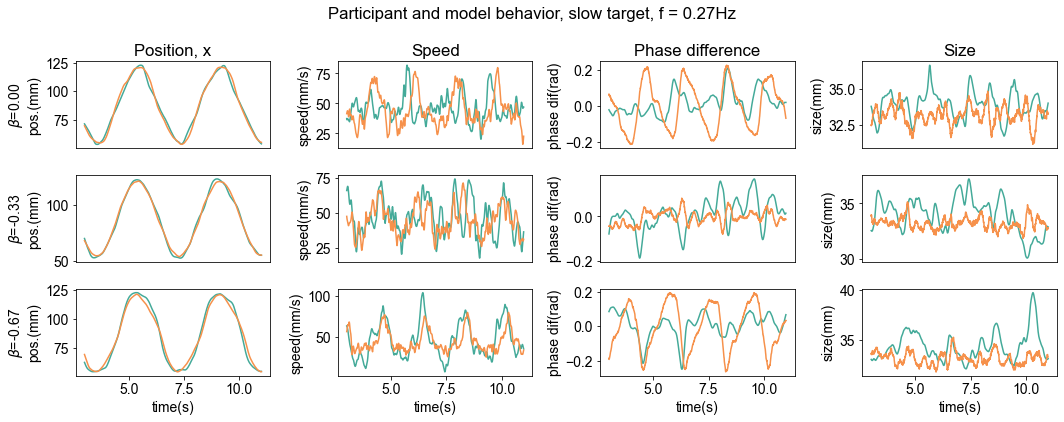

In [31]:
fig, axs = plt.subplots(3,4, figsize=(15, 6))
plt.suptitle(fr"Participant and model behavior, slow target, f = 0.27Hz")

for i, t in enumerate(targets[:3][::-1]):
    m = t.m2    
    c = t.human
    
    take = np.arange(int(3/dt),int((11)/dt))
    ax0,ax1,ax2,ax3 = axs[i, :]
    
    if i == 0:
        ax0.set_title("Position, x")
        ax1.set_title("Speed")
        ax2.set_title("Phase difference")
        ax3.set_title("Size")
    
    ax0.plot(c.t[take], c.x[take], color=colors["cursor"], label="human (P1)")
    ax0.plot(m.t[take], m.x[take], color=colors["model"], label="model")
    
    ax0.set_ylabel(fr"$\beta$={t.betaCV:.2f}" "\n" "pos.(mm)")
    
    ax1.plot(c.t[take], c.V[take], color=colors["cursor"], label="P1")
    ax1.plot(m.t[take], m.V[take], color=colors["model"], label="model")
    ax1.set_ylabel("speed(mm/s)")
    
    ax2.plot(c.t[take], c.dph[take], color=colors["cursor"], label="P1")
    ax2.plot(m.t[take], A(t.data.dph)[take], color=colors["model"], label="model")
    ax2.set_ylabel("phase dif(rad)")
    
    ax3.plot(c.t[take], c.rc[take], color=colors["cursor"], label="P1")
    ax3.plot(m.t[take], A(t.data.rc)[take], color=colors["model"], label="model")
    ax3.set_ylabel("size(mm)")
    
    if i == 2:
        ax0.set_xlabel("time(s)")
        ax1.set_xlabel("time(s)")
        ax2.set_xlabel("time(s)")
        ax3.set_xlabel("time(s)")
    else:
        ax0.set_xticks([])
        ax1.set_xticks([])
        ax2.set_xticks([])
        ax3.set_xticks([])
        

plt.tight_layout()

plt.savefig("..//figures//Figure 6 Participant-model slow.pdf", format="pdf",  bbox_inches = "tight")
plt.show()

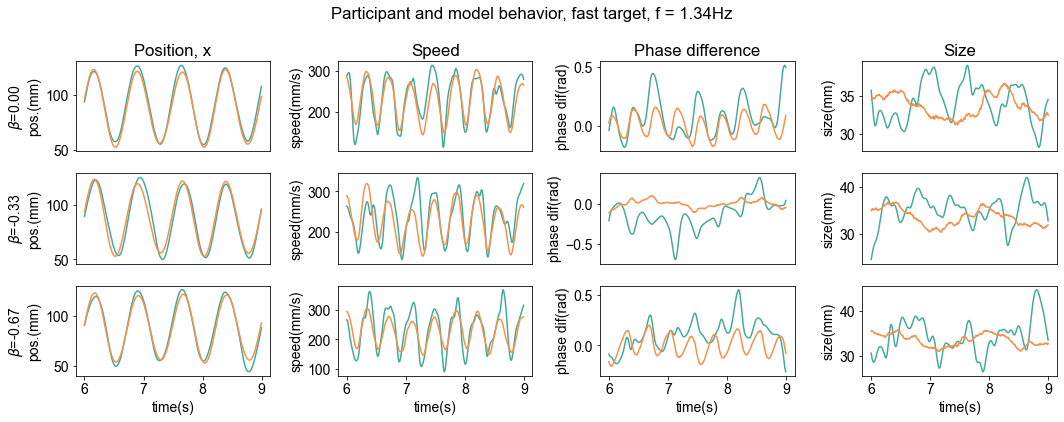

In [32]:
fig, axs = plt.subplots(3,4, figsize=(15, 6))
plt.suptitle(fr"Participant and model behavior, fast target, f = 1.34Hz")

for i, t in enumerate(targets[-3:][::-1]):
    m = t.m2    
    c = t.human
    
    take = np.arange(int(6/dt),int((9)/dt))
    ax0,ax1,ax2,ax3 = axs[i, :]
    
    if i == 0:
        ax0.set_title("Position, x")
        ax1.set_title("Speed")
        ax2.set_title("Phase difference")
        ax3.set_title("Size")
    
    ax0.plot(c.t[take], c.x[take], color=colors["cursor"], label="human (P1)")
    ax0.plot(m.t[take], m.x[take], color=colors["model"], label="model")
    
    ax0.set_ylabel(fr"$\beta$={t.betaCV:.2f}" "\n" "pos.(mm)")
    
    ax1.plot(c.t[take], c.V[take], color=colors["cursor"], label="P1")
    ax1.plot(m.t[take], m.V[take], color=colors["model"], label="model")
    ax1.set_ylabel("speed(mm/s)")
    
    ax2.plot(c.t[take], c.dph[take], color=colors["cursor"], label="P1")
    ax2.plot(m.t[take], A(t.data.dph)[take], color=colors["model"], label="model")
    ax2.set_ylabel("phase dif(rad)")
    
    ax3.plot(c.t[take], c.rc[take], color=colors["cursor"], label="P1")
    ax3.plot(m.t[take], A(t.data.rc)[take], color=colors["model"], label="model")
    ax3.set_ylabel("size(mm)")
    
    if i == 2:
        ax0.set_xlabel("time(s)")
        ax1.set_xlabel("time(s)")
        ax2.set_xlabel("time(s)")
        ax3.set_xlabel("time(s)")
    else:
        ax0.set_xticks([])
        ax1.set_xticks([])
        ax2.set_xticks([])
        ax3.set_xticks([])
        

plt.tight_layout()

plt.savefig("..//figures//Figure 6 Participant-model fast.pdf", format="pdf",  bbox_inches = "tight")

plt.show()